In [1]:
# High-level imports
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# See dkl_mnist.ipynb for explanation of use_toeplitz
gpytorch.functions.use_toeplitz = False

# Make inline plots
%matplotlib inline


In [2]:
from torch.autograd import Variable

# Classifying points
# X is [-1, 1] X [-1, 1] 
# Y values are 1 inside [-0.5, 0.5] X [-0.5, 0.5]
# 201 points along each axis, 201^2 = 40,401 training points
n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1
# Cuda the variables
train_x = Variable(train_x).cuda()
train_y = Variable(train_y).cuda()

In [3]:
# Neural net and optimizer imports
from torch import nn, optim
# Get the RBF kernel
# The GridInterpolationKernel is put on top the RBF kernel to interpolate it between
# the grid inducing points
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
# Gaussian likelihood is a Gaussian with noise added
# Bernoulli likelihood (warping input using normal CDF to [0,1])
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# For GP Classification we use the AdditiveGridInducingVariationalGP model
class GPClassificationModel(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(-1, 1)],
                                                    n_components=2)
        # Constant mean near 0
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # RBF kernel used as covariance module
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Register the log length scale of the RBF kernel as a parameter to be trained
        self.register_parameter('log_outputscale',
                                nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Use the mean and covariance modules
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Scale the covariance matrix by lengthscale
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # The prediction is in the form of a Gaussian Random variable
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred
# Cuda the model and likelihood function
model = GPClassificationModel().cuda()
likelihood = BernoulliLikelihood().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0

# Training function
def train():
    # 25 iterations
    num_iter = 25
    for i in range(num_iter):
        # Zero out the gradients
        optimizer.zero_grad()
        # Output the model prediction
        output = model(train_x)
        # Calculate the loss of the prediction
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        # Report iteration results
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, num_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()

# Time how long the training takes
%time train()

Iter 1/25 - Loss: 23.893   log_lengthscale: 0.000
Iter 2/25 - Loss: 24.747   log_lengthscale: -0.200
Iter 3/25 - Loss: 6.991   log_lengthscale: -0.352
Iter 4/25 - Loss: 8.442   log_lengthscale: -0.508
Iter 5/25 - Loss: 13.991   log_lengthscale: -0.668
Iter 6/25 - Loss: 7.530   log_lengthscale: -0.834
Iter 7/25 - Loss: 2.878   log_lengthscale: -0.997
Iter 8/25 - Loss: 1.821   log_lengthscale: -1.146
Iter 9/25 - Loss: 1.248   log_lengthscale: -1.291
Iter 10/25 - Loss: 1.023   log_lengthscale: -1.430
Iter 11/25 - Loss: 2.092   log_lengthscale: -1.567
Iter 12/25 - Loss: 2.348   log_lengthscale: -1.702
Iter 13/25 - Loss: 1.805   log_lengthscale: -1.837
Iter 14/25 - Loss: 1.562   log_lengthscale: -1.969
Iter 15/25 - Loss: 2.394   log_lengthscale: -2.102
Iter 16/25 - Loss: 1.632   log_lengthscale: -2.239
Iter 17/25 - Loss: 1.661   log_lengthscale: -2.373
Iter 18/25 - Loss: 1.854   log_lengthscale: -2.501
Iter 19/25 - Loss: 1.577   log_lengthscale: -2.623
Iter 20/25 - Loss: 1.014   log_lengths

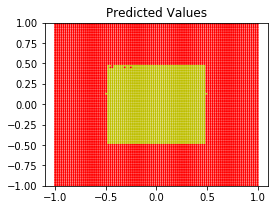

In [6]:
# Switch the model and likelihood into the evaluation mode
model.eval()
likelihood.eval()

# Start the plot, 4x3in
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# 10k test points on grid
n = 100
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
# Cuda variable of test data
test_x = Variable(test_x).cuda()
# Make predictions
predictions = likelihood(model(test_x))

# define plotting function
def ax_plot(ax, rand_var, title):
    # ax = axes object
    # rand_var = predictions
    # title = plot title
    
    # Get the mean of the predictiono, check whether > 0.5: this returns 0 or 1
    # Multiply by 2 and subtract 1, resulting in label of -1 or 1
    # Put the data on the cpu as a numpy array
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.cpu().numpy()
    # Define colors to use
    color = []
    for i in range(len(pred_labels)):
        # 1 are yellow, -1 are red
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot the data
    ax.scatter(test_x.data[:, 0].cpu().numpy(), test_x.data[:, 1].cpu().numpy(), color=color, s=1)
    ax.set_ylim([-1, 1])
    ax.set_title(title)

ax_plot(observed_ax, predictions, 'Predicted Values')    